In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from hdbscan.validity import validity_index     # DBCV evaluation metric


# =========================== Plotting function ===========================
def plot_clustering_results(X, labels, centers, silhouette_avg, n_clusters=4, 
                            cluster_plot_name = "Clustering Results", 
                            silhouette_plot_name = "Silhouette Score"):
    """
    Plots the clustering results and the silhouette scores for each sample.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data points.
    labels : array-like, shape (n_samples,)
        The cluster labels for each data point.
    centers : array-like, shape (n_clusters, n_features), optional
        The coordinates of the cluster centers. If None, no centers are plotted.
    silhouette_avg : float
        The average silhouette score for all the samples.
    n_clusters : int, optional, default=4
        The number of clusters.

    Returns:
    None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the clustering result
    ax1.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
    if centers is not None:
        ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.set_title(cluster_plot_name)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax2.set_title(silhouette_plot_name)
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

# ========================= kMeans model ===========================
def kMeans_model(X, y, n_clus, max_iteration):
    # Train a k-Means clustering model
    kmeans = KMeans(n_clusters = n_clus, max_iter = max_iteration, init = 'random', random_state = 100)
    kmeans.fit(X)
    y_predict = kmeans.predict(X)

    # Evaluate model
    silhouette_avg = silhouette_score(X, y_predict)
    print(f"K-Means Silhouette Score: {silhouette_avg}")

    # Plotting
    centers = kmeans.cluster_centers_
    plot_clustering_results(X, y_predict, centers, silhouette_avg, n_clusters = n_clus, 
                            cluster_plot_name = "kMeans Clustering Results", 
                            silhouette_plot_name = "kMeans Silhouette Score")

# =================== Agglomerative clustering =====================
def hierarchical_model(X, y, n_clus):
    # Perform agglomerative clustering
    Z = linkage(X, 'ward')

    # Plot the dendrogram
    plt.figure(figsize=(5, 3))
    dendrogram(Z)
    plt.title('Hierarchical Clustering Dendrogram (Agglomerative)')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

    # Train an agglomerative clustering model
    agg_clustering = AgglomerativeClustering(n_clusters=n_clus, linkage = 'ward', metric = 'euclidean')
    y_agg = agg_clustering.fit_predict(X)

    # Evaluate the model
    silhouette_avg = silhouette_score(X, y_agg)
    print(f"Agglomerative Clustering Silhouette Score: {silhouette_avg}")

    # Plot the clustering results using the custom function
    plot_clustering_results(X, y_agg, None, silhouette_avg, n_clusters = n_clus, 
                            cluster_plot_name = "Hierarchical Clustering Results", 
                            silhouette_plot_name = "Hierarchical Silhouette Score")

# =========================== DBSCAN Model ===========================
def DBSCAN_model(X, y, eps, min_samples):
    dbscan_model = DBSCAN(eps = eps, min_samples=min_samples)
    dbscan_model.fit(X)
    y_predict = dbscan_model.labels_
    n_clusters = len(set(y_predict)) - (1 if -1 in y_predict else 0)

    if n_clusters <= 1:
        print("Silhouette Score cannot be computed: less than 2 clusters found.")
        silhouette_avg = None
    else:
        silhouette_avg = silhouette_score(X, y_predict)
        print(f"DBSCAN Silhouette Score: {silhouette_avg:.3f}")

    # DBCV calculation requires pairwise distances
    distance_matrix = pairwise_distances(X)

    # Filter noise points (label = -1), DBCV does not handle them directly
    mask = y_predict != -1
    X_filtered = X[mask]
    labels_filtered = y_predict[mask]

    # Compute DBCV score
    dbcv_score = validity_index(X_filtered, labels_filtered, metric='euclidean')
    print(f"DBCV Score: {dbcv_score:.3f}")

    # Plot clustering results
    plot_clustering_results(X, y_predict, centers = None, silhouette_avg = silhouette_avg, n_clusters=n_clusters, 
                            cluster_plot_name = "DBSCAN Clustering Results", 
                            silhouette_plot_name = "DBSCAN Silhouette Score")
    
# =========================== DBSCAN Grid Search ===========================
def DBSCAN_grid_search(X):
    for eps in [0.1, 0.3, 0.5, 0.7, 1.0]:
        for min_samples in [3, 5, 7, 9, 11]:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            y_predict = dbscan.fit_predict(X)

            # Count the number of clusters. Noise is excluded (labeled as -1)
            n_clusters = len(set(y_predict)) - (1 if -1 in y_predict else 0)

            # Do DBCV evaluation if there are at least 2 clusters
            if n_clusters > 1:

                # First, we're filtering out noise
                noise = y_predict != -1         
                X_filtered = X[noise]
                y_predict_filtered = y_predict[noise]

                # Check again, see if we still have at least 2 clusters after filtering out noise
                if len(set(y_predict_filtered)) > 1:
                    dbcv = validity_index(X_filtered, y_predict_filtered, metric='euclidean')
                    dbcv_str = f"{dbcv:.3f}"

                # Print DBCV results
                print(f"eps={eps}, min_samples={min_samples} → clusters={n_clusters}, DBCV={dbcv_str}")
            
            else:
                print(f"eps={eps}, min_samples={min_samples} → less than 2 clusters")


# For non-sphere data

K-Means Silhouette Score: 0.4862461316701149


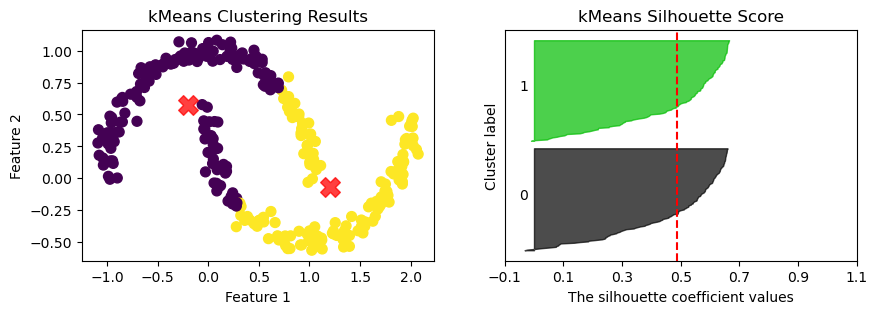

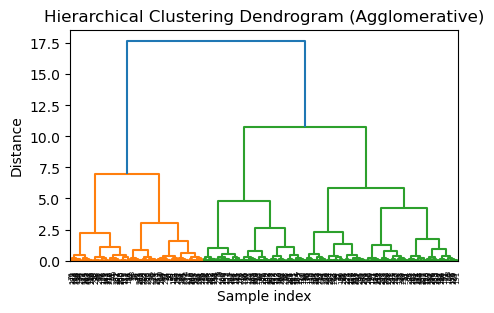

Agglomerative Clustering Silhouette Score: 0.43967977512559364


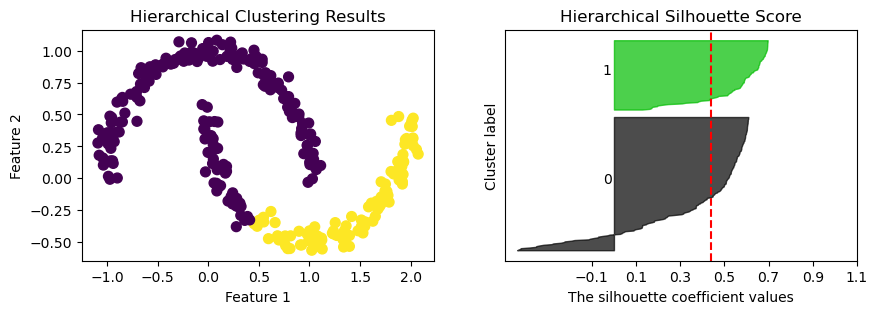

DBSCAN Silhouette Score: 0.326
DBCV Score: 0.538


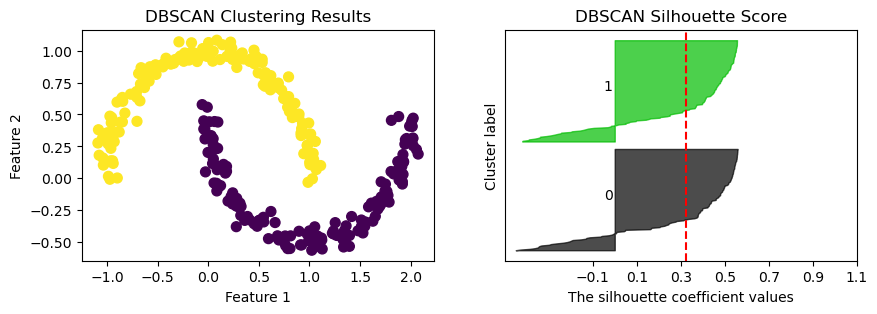

eps=0.1, min_samples=3 → clusters=8, DBCV=-0.050
eps=0.1, min_samples=5 → clusters=11, DBCV=0.274
eps=0.1, min_samples=7 → clusters=13, DBCV=0.403
eps=0.1, min_samples=9 → clusters=15, DBCV=0.496
eps=0.1, min_samples=11 → clusters=5, DBCV=0.747
eps=0.3, min_samples=3 → clusters=2, DBCV=0.538
eps=0.3, min_samples=5 → clusters=2, DBCV=0.538
eps=0.3, min_samples=7 → clusters=2, DBCV=0.538
eps=0.3, min_samples=9 → clusters=2, DBCV=0.538
eps=0.3, min_samples=11 → clusters=2, DBCV=0.538
eps=0.5, min_samples=3 → less than 2 clusters
eps=0.5, min_samples=5 → less than 2 clusters
eps=0.5, min_samples=7 → less than 2 clusters
eps=0.5, min_samples=9 → less than 2 clusters
eps=0.5, min_samples=11 → less than 2 clusters
eps=0.7, min_samples=3 → less than 2 clusters
eps=0.7, min_samples=5 → less than 2 clusters
eps=0.7, min_samples=7 → less than 2 clusters
eps=0.7, min_samples=9 → less than 2 clusters
eps=0.7, min_samples=11 → less than 2 clusters
eps=1.0, min_samples=3 → less than 2 clusters
eps=1.

In [27]:
from sklearn.datasets import make_moons

# Make data
X, y = make_moons(n_samples = 300, noise = 0.05, random_state=100)

# Run different models
kMeans_model(X, y, n_clus=2, max_iteration = 100)
hierarchical_model(X, y, n_clus=2)
DBSCAN_model(X, y, eps=0.3, min_samples=5)

# Find best DBSCAN parameters
DBSCAN_grid_search(X)
            

# For spherical data

K-Means Silhouette Score: 0.7834063831359415


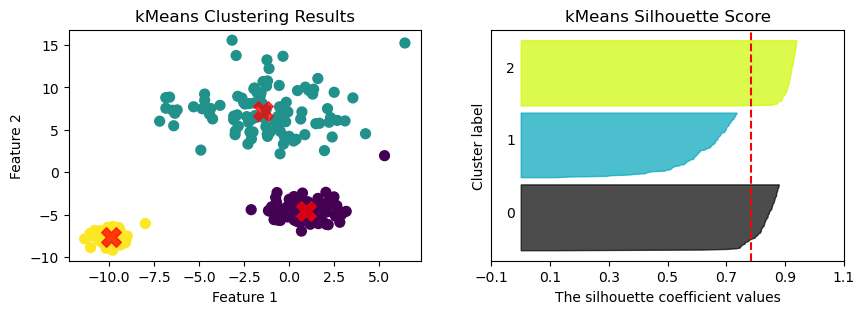

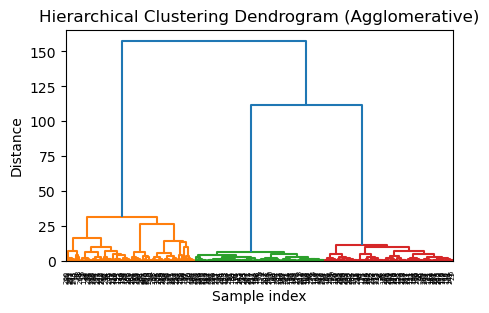

Agglomerative Clustering Silhouette Score: 0.7836275022574155


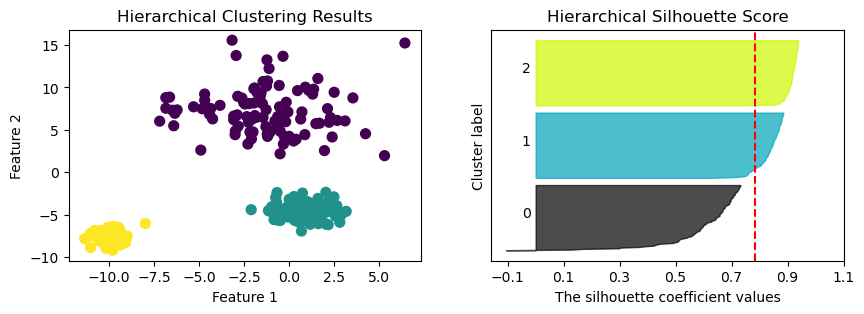

DBSCAN Silhouette Score: 0.765
DBCV Score: 0.885


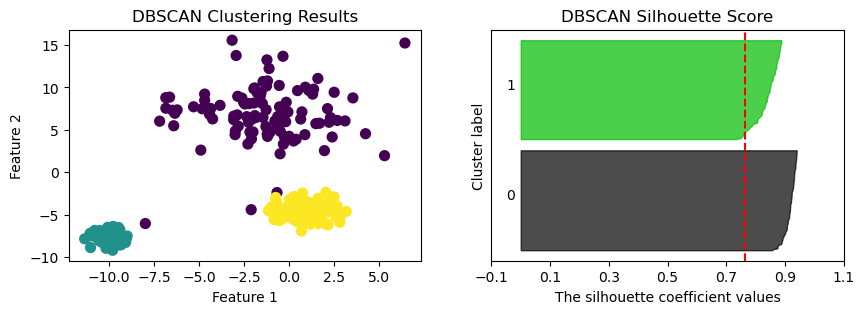

eps=0.1, min_samples=3 → clusters=7, DBCV=0.579
eps=0.1, min_samples=5 → less than 2 clusters
eps=0.1, min_samples=7 → less than 2 clusters
eps=0.1, min_samples=9 → less than 2 clusters
eps=0.1, min_samples=11 → less than 2 clusters
eps=0.3, min_samples=3 → clusters=14, DBCV=0.179
eps=0.3, min_samples=5 → clusters=7, DBCV=0.848
eps=0.3, min_samples=7 → clusters=2, DBCV=0.939
eps=0.3, min_samples=9 → clusters=2, DBCV=-0.268
eps=0.3, min_samples=11 → less than 2 clusters
eps=0.5, min_samples=3 → clusters=12, DBCV=0.630
eps=0.5, min_samples=5 → clusters=6, DBCV=0.557
eps=0.5, min_samples=7 → clusters=2, DBCV=0.923
eps=0.5, min_samples=9 → clusters=2, DBCV=0.934
eps=0.5, min_samples=11 → clusters=2, DBCV=0.936
eps=0.7, min_samples=3 → clusters=12, DBCV=0.780
eps=0.7, min_samples=5 → clusters=8, DBCV=0.832
eps=0.7, min_samples=7 → clusters=2, DBCV=0.887
eps=0.7, min_samples=9 → clusters=2, DBCV=0.909
eps=0.7, min_samples=11 → clusters=2, DBCV=0.911
eps=1.0, min_samples=3 → clusters=6, DBCV=

In [28]:
from sklearn.datasets import make_blobs

# Make data
X, y = make_blobs(n_samples = 300, centers = 3, cluster_std = [1.0, 2.5, 0.5], random_state = 100)

# Run different models
kMeans_model(X, y, n_clus=3, max_iteration = 100)
hierarchical_model(X, y, n_clus=3)
DBSCAN_model(X, y, eps=1, min_samples=11)

# Find best DBSCAN parameters
DBSCAN_grid_search(X)
        


# For circle data

K-Means Silhouette Score: 0.3554396523948981


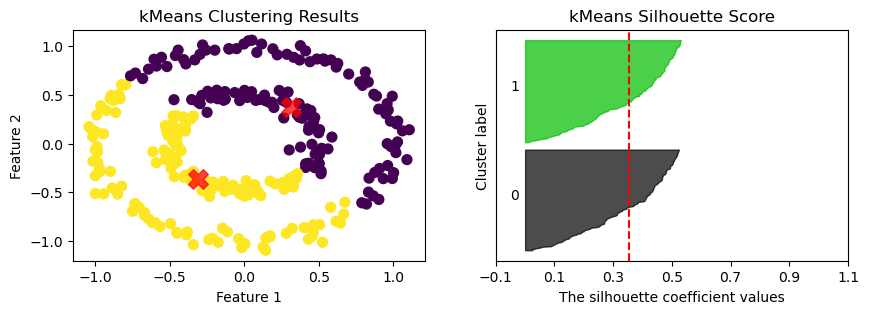

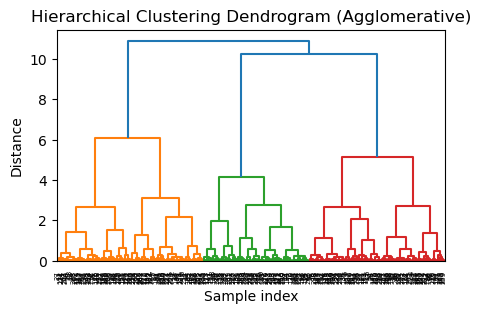

Agglomerative Clustering Silhouette Score: 0.30554037445145976


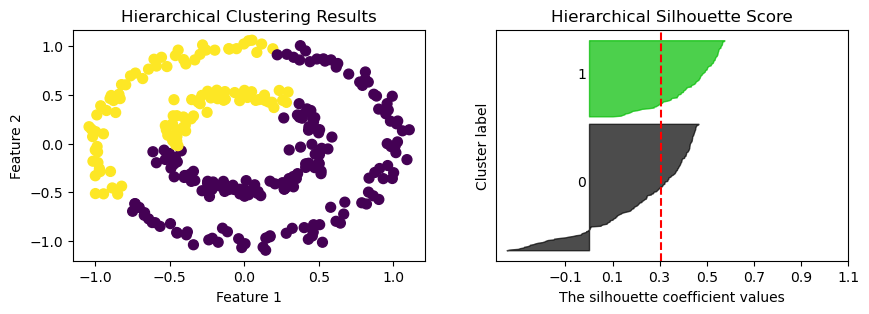

DBSCAN Silhouette Score: 0.111
DBCV Score: 0.108


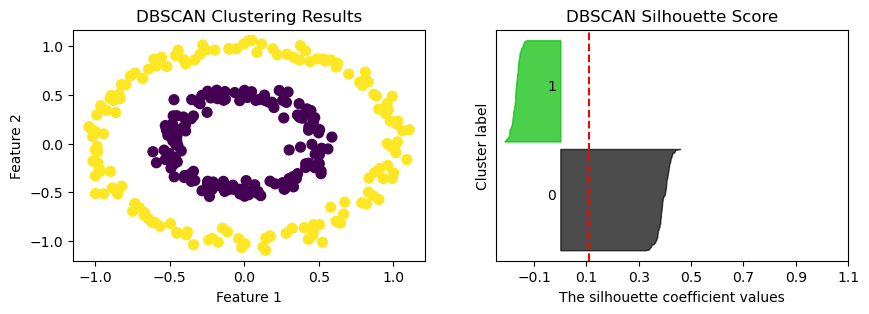

eps=0.1, min_samples=3 → clusters=21, DBCV=0.226
eps=0.1, min_samples=5 → clusters=17, DBCV=0.395
eps=0.1, min_samples=7 → clusters=7, DBCV=0.390
eps=0.1, min_samples=9 → clusters=8, DBCV=0.271
eps=0.1, min_samples=11 → clusters=4, DBCV=0.801
eps=0.3, min_samples=3 → clusters=2, DBCV=0.108
eps=0.3, min_samples=5 → clusters=2, DBCV=0.108
eps=0.3, min_samples=7 → clusters=2, DBCV=0.108
eps=0.3, min_samples=9 → clusters=2, DBCV=0.108
eps=0.3, min_samples=11 → clusters=2, DBCV=0.108
eps=0.5, min_samples=3 → less than 2 clusters
eps=0.5, min_samples=5 → less than 2 clusters
eps=0.5, min_samples=7 → less than 2 clusters
eps=0.5, min_samples=9 → less than 2 clusters
eps=0.5, min_samples=11 → less than 2 clusters
eps=0.7, min_samples=3 → less than 2 clusters
eps=0.7, min_samples=5 → less than 2 clusters
eps=0.7, min_samples=7 → less than 2 clusters
eps=0.7, min_samples=9 → less than 2 clusters
eps=0.7, min_samples=11 → less than 2 clusters
eps=1.0, min_samples=3 → less than 2 clusters
eps=1.0,

In [23]:
from sklearn.datasets import make_circles

# Make data
X, y = make_circles(n_samples = 300, factor = 0.5, noise = 0.05, random_state=100)

# Run different models
kMeans_model(X, y, n_clus=2, max_iteration = 100)
hierarchical_model(X, y, n_clus=2)
DBSCAN_model(X, y, eps=0.3, min_samples=10)

# Find best DBSCAN parameters
DBSCAN_grid_search(X)
